# $min(\Delta R_{jj}^{HC1})$ sanity checks

**Motivation:** We were seeing some promising results with significance metrics for the stats only limits.

However, they were completely washed away with the systematics limits.

Sean suggested moving on to the $m\min (\Delta R)$ instead, since (at least w/ this newest pairAGraph training we've been seeing smaller systematics with the min_dR, so Sean suggested switching over to min_dR for these newer checks 


In [2]:
import dask.dataframe as dd
import pyarrow.parquet as pq
import pyarrow as pa

import pyhf

import os
os.sys.path+= ['../RRevolution/code/','../code/']
from analysis import getXhh
from utils import mcToYr

from postprocess import calc_bstrap

from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2

import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot

import matplotlib.pyplot as plt
from matplotlib import gridspec

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)


%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


## Step 1: SR Proposal

See if the proposal for the new SR is impacted by the 
- X_wt cut
- buckets
- VBF veto

In [ ]:
sdf_btag = pd.read_parquet('../data/SMNR_mc16d-JUN20_2b1jBucketBug/df_min_dR1_3b_btag_sort.parquet')

sdf_Db   = pd.read_parquet('../data/SMNR_mc16d-JUN20_2b1jBucketBug/df_min_dR1_3b_Db_sort.parquet')

Let's let purple be the Db sort, pink be the Db sort, and orange be RR.

In [ ]:
for sdfi,color in zip([sdf_Db, sdf_btag],['blueviolet','deeppink']):
    
    m = (sdfi.abs_deta_hh < 1.5)
    
    plt.hist(sdfi.loc[m,'m_h1'],100,(50,200),
             histtype='step',color=color,lw=3,
             weights=sdfi.loc[m,'mc_sf'])
plt.xlabel('m_h1')

In [ ]:
for sdfi,color in zip([sdf_Db, sdf_btag],['blueviolet','deeppink']):
    
    m = (sdfi.abs_deta_hh < 1.5)& (sdfi.X_wt > 1.5) 
    
    for mi,ls in zip([True, (sdfi.bucket != 0)],['-','--']):
        plt.hist(sdfi.loc[m&mi,'m_h1'],100,(50,200),
                 histtype='step',color=color,lw=3,ls=ls,
                 weights=sdfi.loc[m&mi,'mc_sf'])
        
        
plt.xlabel('m_h1')

Ohhhhhh.... right!! Buckets have a *huge* impact on signal (dayum)!!

In [3]:
f_sig = uproot.open('../data/RR/NNT_DEC20_MDR_VEC/MC/600043_mc16d/NanoNTuple.root')
sdf = f_sig['fullmassplane'].pandas.df()

In [6]:
from utils import L

In [ ]:
for c in ['m_h1','m_h2']:
    
    plt.figure()
    for sdfi,color,s in zip([sdf_Db, sdf_btag],['blueviolet','deeppink'],['Db','b-tag']):

        m = (sdfi.ntag >= 4)&(sdfi.abs_deta_hh < 1.5)& (sdfi.X_wt > 1.5) 

        for mi,ls,t in zip([True, (sdfi.bucket != 0)],['-','--'],['pre','post']):
            plt.hist(sdfi.loc[m&mi,c],100,(0,200),label=f'{s}, {t} bucket',
                     histtype='step',color=color,lw=3,ls=ls,
                     weights=sdfi.loc[m&mi,'mc_sf'])


    plt.hist(sdf.loc[sdf.ntag>=4,c],100,(0,200),label='RR fullmassplane',
             histtype='step',color='darkorange',lw=3,ls=ls,
             weights=L[17]*sdf.loc[sdf.ntag>=4,'mc_sf'])

    plt.xlabel(f'{c} [GeV]')
    plt.ylabel('Entries')
    plt.legend(loc='upper left')
    plt.title('4b min(dR) SM: (buggy 2b1j bucket)')

Ok - so this is saying that the VBF veto is *neglibible* (or that I haven't applied it yet lmao.)

In [4]:
np.sum(sdf.loc[sdf.pass_vbf_sel,'mc_sf'])/np.sum(sdf.mc_sf)

0.024012987

In [5]:
np.sum(sdf.loc[(sdf.pass_vbf_sel) & (sdf.kinematic_region==0),'mc_sf'])/np.sum(sdf.loc[sdf.kinematic_region==0,'mc_sf'])

0.016865272

In [8]:
x1,y1 = 124,117

sdf[f'Xhh_{x1}_{y1}'] = getXhh(*sdf[['m_h1','m_h2']].values.T,x1,y1)

In [17]:
smask = (~sdf.pass_vbf_sel) & (sdf.Xhh_124_117 < 1.6)&(sdf.ntag>=4)

np.sum(sdf.loc[smask,'mc_sf'])*L[17]

9.550672397017479

In [18]:
smask = (~sdf.pass_vbf_sel) & (sdf.ntag>=4) & (sdf.kinematic_region==0)

np.sum(sdf.loc[smask,'mc_sf'])*L[17]

9.077823214977979

In [15]:
sdf.X_wt.min()

1.5000825

Ok - so it makes sense this is a % level effect, it's only taking away 2% of our signal.

### Signal region proposals

## Step 2: Compare background estimates

**Goal:** Just to connect some of the dots between what the nominal estimate b/w these 2 configurations.

In [3]:
f0   = uproot.open('../data/SeanFiles/Db_sort/min-dR1/4b/data_min_dR_17_NN_100_bootstraps.root')
bdf0 = f0['sig'].pandas.df()

f   = uproot.open('../data/RR/bkg_ests/test_Xwt_change/MDR_VEC/data17_NN_100_bootstraps_IQR.root')
bdf = f['sig'].pandas.df()

In [49]:
f1 = uproot.open('../data/SeanFiles/data_OCT27/data_min_dR1_all_17_NN_100_bootstraps_IQR.root')
bdf1 = f1['sig'].pandas.df()

The one with my private fw (a.k.a, `bdf0`) needs to have the $X_{wt}$ cut applied for apples-to-apples comparison.

In [50]:
for bdfi,fi in zip([bdf0,bdf,bdf1],[f0,f,f1]):
    bdfi['w_2b'] = bdfi['NN_d24_weight_bstrap_med_17']*fi[b'NN_norm_bstrap_med_17;1']._fVal
    
    bdfi['w_2b_VR'] = bdfi['NN_d24_weight_VRderiv_bstrap_med_17']*fi[b'NN_norm_VRderiv_bstrap_med_17;1']._fVal    

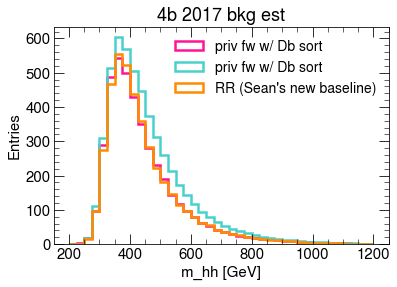

In [51]:
nb, r = 40, (200,1200)

n,e,_ = plt.hist(bdf0.loc[(bdf0.X_wt > 1.5)&(bdf0.ntag==2),'m_hh'],nb,r,
                 histtype='step',label='priv fw w/ Db sort',lw=2.5,color='deeppink',
                 weights=bdf0.loc[(bdf0.X_wt > 1.5)&(bdf0.ntag==2),'w_2b'])

rr,_,_ = plt.hist(bdf.loc[bdf.ntag==2,'m_hh'],nb,r,
                 histtype='step',label='RR (Sean\'s new baseline)',lw=2.5,
                 color='darkorange',weights=bdf.loc[bdf.ntag==2,'w_2b'])

plt.xlabel('m_hh [GeV]')
plt.ylabel('Entries')
plt.title('4b 2017 bkg est')
plt.legend()

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '4b 2017 bkg est')

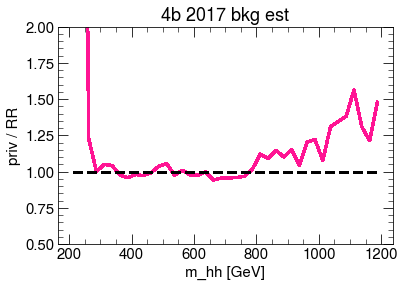

In [36]:
plt.plot(xx, n/rr,'deeppink')
plt.ylim(0.5,2)
plt.plot(xx, np.ones_like(xx),'k--')

plt.xlabel('m_hh [GeV]')
plt.ylabel('priv / RR')
plt.title('4b 2017 bkg est')

But right, we know there was a buggy bucket here, so could we look at the buckets in the 2b1j bucket that *failed* the 2b1j trigger??

In [46]:
# for c in bdf0.columns:
#     #if 'HLT' in c: 
#     print(c)

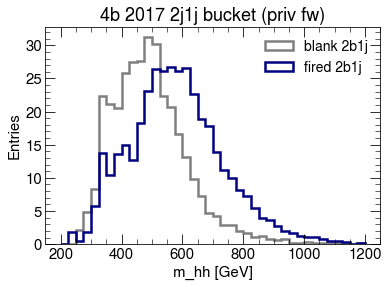

In [47]:
bmask = (bdf0.X_wt > 1.5)&(bdf0.ntag==2) & (bdf0.bucket==2) 

m0 = bmask & ~bdf0.HLT_j110_gsc150_boffperf_split_2j35_gsc55_bmv2c1070_split_L1J85_3J30
m1 = bmask & bdf0.HLT_j110_gsc150_boffperf_split_2j35_gsc55_bmv2c1070_split_L1J85_3J30

plt.hist(bdf0.loc[m0,'m_hh'],nb,r,
         histtype='step',label='blank 2b1j',
         lw=2.5,color='grey',
         weights=bdf0.loc[m0,'w_2b'])
plt.hist(bdf0.loc[m1,'m_hh'],nb,r,
         histtype='step',label='fired 2b1j',
         lw=2.5,color='navy',
         weights=bdf0.loc[m1,'w_2b'])

plt.legend()

plt.xlabel('m_hh [GeV]')
plt.ylabel('Entries')
plt.title('4b 2017 2j1j bucket (priv fw)')
plt.legend()


Let's also compare the systematics b/w the two...

**First let's see if there's any diff on the systematics pre vs post $X_{wt}$ for the training w/ the private samples**

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


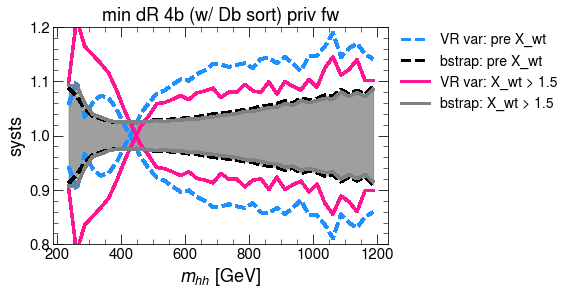

In [31]:
yr = 17

xx = 0.5 * (e[:-1] + e[1:])

for bmask,c0,c1,ls,l in zip([bdf0.ntag==2,(bdf0.X_wt > 1.5)&(bdf0.ntag==2)],
                            ['k','grey'], ['dodgerblue','deeppink'],['--','-'],
                            ['pre X_wt','X_wt > 1.5']):

    b    = np.histogram(bdf0.loc[bmask,'m_hh'],nb,r,weights=bdf0.loc[bmask,'w_2b'])[0]
    b_vr = np.histogram(bdf0.loc[bmask,'m_hh'],nb,r,weights=bdf0.loc[bmask,'w_2b_VR'])[0]

    norm     = f0[f'NN_norm_bstrap_med_{yr}']._fVal
    norm_IQR = f0[f'NN_norm_bstrap_IQR_{yr}']._fVal

    bstrap = calc_bstrap(bdf0[bmask], 'm_hh', yr, norm, norm_IQR, nb, r,'ntag')
    
    err =( 2*b - b_vr)/ b

    plt.plot(xx,err,c1,ls=ls,label=f'VR var: {l}')
    plt.plot(xx,2-err,c1,ls=ls)

    dbs = bstrap / b
    plt.fill_between(xx,1-dbs,1+dbs,color='grey',alpha=0.5)

    plt.plot(xx,1-dbs,c0,ls=ls,label=f'bstrap: {l}')
    plt.plot(xx,1+dbs,c0,ls=ls)
    
plt.ylabel('systs',fontsize=18)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.title(f'min dR 4b (w/ Db sort) priv fw')
plt.ylim(0.8,1.2)
plt.legend(bbox_to_anchor=(1,1.03))
plt.show()


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


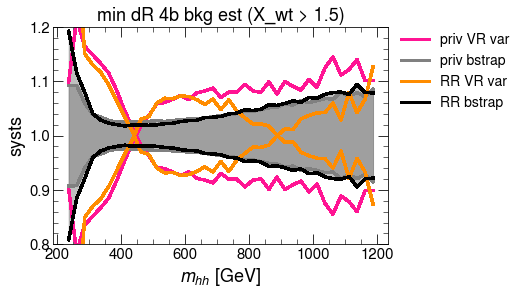

In [32]:
plt.figure()
plt.plot(xx,err,c1,ls=ls,label=f'priv VR var')
plt.plot(xx,2-err,c1,ls=ls)

dbs = bstrap / b
plt.fill_between(xx,1-dbs,1+dbs,color='grey',alpha=0.5)

plt.plot(xx,1-dbs,c0,ls=ls,label=f'priv bstrap')
plt.plot(xx,1+dbs,c0,ls=ls)
    
'''
And now for RR
'''
c0,c1='k','darkorange'
b    = np.histogram(bdf.loc[bdf.ntag==2,'m_hh'],nb,r,
                    weights=bdf.loc[bdf.ntag==2,'w_2b'])[0]
b_vr = np.histogram(bdf.loc[bdf.ntag==2,'m_hh'],nb,r,
                    weights=bdf.loc[bdf.ntag==2,'w_2b_VR'])[0]

norm     = f[f'NN_norm_bstrap_med_{yr}']._fVal
norm_IQR = f[f'NN_norm_bstrap_IQR_{yr}']._fVal

bstrap = calc_bstrap(bdf[bdf.ntag==2], 'm_hh', yr, norm, norm_IQR, nb, r,'ntag')

err =( 2*b - b_vr)/ b

plt.plot(xx,err,c1,ls=ls,label=f'RR VR var')
plt.plot(xx,2-err,c1,ls=ls)

dbs = bstrap / b
plt.fill_between(xx,1-dbs,1+dbs,color='grey',alpha=0.5)

plt.plot(xx,1-dbs,c0,ls=ls,label=f'RR bstrap')
plt.plot(xx,1+dbs,c0,ls=ls)


plt.ylabel('systs',fontsize=18)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.title(f'min dR 4b bkg est (X_wt > 1.5)')
plt.ylim(0.8,1.2)
plt.legend(bbox_to_anchor=(1,1.03))
plt.show()



And now... c.f. both to RR.

Ok... wow, this is *amazing* that it gets so much better haha.

**Maybe the next Q is how this translates into limits??**

One other thing I would like to look into is how all of this compares to the training we did w/ the $b$-tag sort for min(dR).

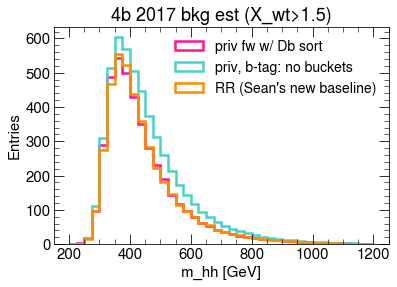

In [58]:
nb, r = 40, (200,1200)

n,e,_ = plt.hist(bdf0.loc[(bdf0.X_wt > 1.5)&(bdf0.ntag==2),'m_hh'],nb,r,
                 histtype='step',label='priv fw w/ Db sort',lw=2.5,color='deeppink',
                 weights=bdf0.loc[(bdf0.X_wt > 1.5)&(bdf0.ntag==2),'w_2b'])

o,e,_ = plt.hist(bdf1.loc[(bdf1.X_wt > 1.5)&(bdf1.ntag==2),'m_hh'],nb,r,
                 histtype='step',label='priv, b-tag: no buckets',lw=2.5,color='mediumturquoise',
                 weights=bdf1.loc[(bdf1.X_wt > 1.5)&(bdf1.ntag==2),'w_2b'])


rr,_,_ = plt.hist(bdf.loc[bdf.ntag==2,'m_hh'],nb,r,
                 histtype='step',label='RR (Sean\'s new baseline)',lw=2.5,
                 color='darkorange',weights=bdf.loc[bdf.ntag==2,'w_2b'])

plt.xlabel('m_hh [GeV]')
plt.ylabel('Entries')
plt.title('4b 2017 bkg est (X_wt>1.5)')
plt.legend()

Oh, right, no buckets... v,v, different

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


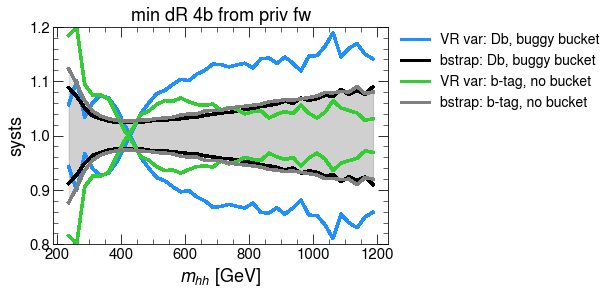

In [66]:
# Systs pre-Xwt
for bdfi,fi,c0,c1,l in zip([bdf0,bdf1],[f0,f1],['k','grey'], ['dodgerblue','limegreen'],
                           ['Db, buggy bucket','b-tag, no bucket']):

    b    = np.histogram(bdfi.loc[bdfi.ntag==2,'m_hh'],nb,r,weights=bdfi.loc[bdfi.ntag==2,'w_2b'])[0]
    b_vr = np.histogram(bdfi.loc[bdfi.ntag==2,'m_hh'],nb,r,weights=bdfi.loc[bdfi.ntag==2,'w_2b_VR'])[0]

    norm     = fi[f'NN_norm_bstrap_med_{yr}']._fVal
    norm_IQR = fi[f'NN_norm_bstrap_IQR_{yr}']._fVal

    bstrap = calc_bstrap(bdfi[bdfi.ntag==2], 'm_hh', yr, norm, norm_IQR, nb, r,'ntag')
    
    err =( 2*b - b_vr)/ b

    plt.plot(xx,err,c1,ls=ls,label=f'VR var: {l}')
    plt.plot(xx,2-err,c1,ls=ls)

    dbs = bstrap / b
    plt.fill_between(xx,1-dbs,1+dbs,color='grey',alpha=0.2)

    plt.plot(xx,1-dbs,c0,ls=ls,label=f'bstrap: {l}')
    plt.plot(xx,1+dbs,c0,ls=ls)
    
plt.ylabel('systs',fontsize=18)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.title(f'min dR 4b from priv fw')
plt.ylim(0.8,1.2)
plt.legend(bbox_to_anchor=(1,1.03))
plt.show()



We've seen this before that the buckets decrease the high mass variation. It seems to be *exactly* the opposite here... hmmmmmmmmmm.

**Look at the m_hh for *unwieghted* 2b**

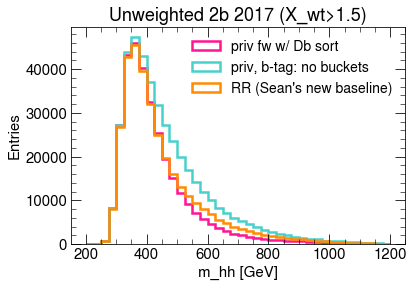

In [61]:
n,e,_ = plt.hist(bdf0.loc[(bdf0.X_wt > 1.5)&(bdf0.ntag==2),'m_hh'],nb,r,
                 histtype='step',label='priv fw w/ Db sort',lw=2.5,color='deeppink')

o,e,_ = plt.hist(bdf1.loc[(bdf1.X_wt > 1.5)&(bdf1.ntag==2),'m_hh'],nb,r,
                 histtype='step',label='priv, b-tag: no buckets',lw=2.5,color='mediumturquoise')

rr,_,_ = plt.hist(bdf.loc[bdf.ntag==2,'m_hh'],nb,r,color='darkorange',
                  histtype='step',label='RR (Sean\'s new baseline)',lw=2.5)

plt.xlabel('m_hh [GeV]')
plt.ylabel('Entries')
plt.title('Unweighted 2b 2017 (X_wt>1.5)')
plt.legend()
plt.show()

Ooooooh - the diff b/w orange and pink is super interestng. Could it be the difference b/w the 2b jet selecion *or* the trigger buckets??

In [67]:
for bdfi,v in zip([bdf0,bdf],['Db','quantile']):
    
    Db_cols = [f'{v}_h{i}_j{j}' for i,j in product([1,2],[1,2])]

    bdfi['minQ'] = np.min(bdfi[Db_cols],axis=1)
    bdfi['numLoose'] = np.sum(bdfi[Db_cols]==2,axis=1)

Text(0.5, 0.98, 'Unweighted 2b 2017 SR (X_wt>1.5)')

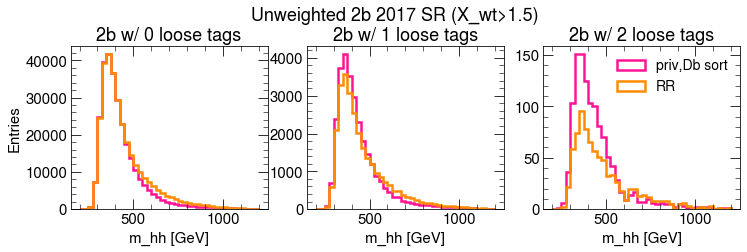

In [73]:
fig, axes = plt.subplots(1,3,figsize=(12,3))

for nl,ax in zip([0,1,2],axes):

    ax.hist(bdf0.loc[(bdf0.X_wt > 1.5)&(bdf0.ntag==2)&(bdf0.numLoose==nl),'m_hh'],nb,r,
            histtype='step',label='priv,Db sort',lw=2.5,color='deeppink')

    ax.hist(bdf.loc[(bdf.ntag==2)&(bdf.numLoose==nl),'m_hh'],nb,r,color='darkorange',
            histtype='step',label='RR',lw=2.5)
    
    ax.set_xlabel('m_hh [GeV]')
    ax.set_title(f'2b w/ {nl} loose tags')
    
axes[0].set_ylabel('Entries')
axes[-1].legend()

fig.suptitle('Unweighted 2b 2017 SR (X_wt>1.5)',va='bottom')

Ok, I thought this 

In [ ]:
trig_yr = trigger_lut(year)
bucket_config = bucket_config_generator( cut_bucket1=325, 
                                         cut_bucket2=168.75, 
                                         cut_bucket3=900,
                                         t_1b  =trig_yr["1b"], 
                                         t_2b1j=trig_yr["2b1j"],
                                         t_2bHT=trig_yr["2bHT"],
                                         t_2b2j=trig_yr["2b2j"]
                                       )

#df = assign_bucket(df, bucket_config)
dat = dat.map_partitions(assign_bucket,bucket_config)


In [59]:
# # Systs pre-Xwt
# for bdfi,fi,c0,c1,l in zip([bdf0,bdf1],[f0,f1],['k','grey'], ['dodgerblue','limegreen'],
#                            ['Db, buggy bucket','b-tag, no bucket']):

    
#     bmask = (bdfi.ntag==2) & (bdfi.X_wt > 1.5)
    
#     b    = np.histogram(bdfi.loc[bmask,'m_hh'],nb,r,weights=bdfi.loc[bmask,'w_2b'])[0]
#     b_vr = np.histogram(bdfi.loc[bmask,'m_hh'],nb,r,weights=bdfi.loc[bmask,'w_2b_VR'])[0]

#     norm     = fi[f'NN_norm_bstrap_med_{yr}']._fVal
#     norm_IQR = fi[f'NN_norm_bstrap_IQR_{yr}']._fVal

#     bstrap = calc_bstrap(bdfi[bdfi.ntag==2], 'm_hh', yr, norm, norm_IQR, nb, r,'ntag')
    
#     err =( 2*b - b_vr)/ b

#     plt.plot(xx,err,c1,ls=ls,label=f'VR var: {l}')
#     plt.plot(xx,2-err,c1,ls=ls)

#     dbs = bstrap / b
#     plt.fill_between(xx,1-dbs,1+dbs,color='grey',alpha=0.5)

#     plt.plot(xx,1-dbs,c0,ls=ls,label=f'bstrap: {l}')
#     plt.plot(xx,1+dbs,c0,ls=ls)
    
# plt.ylabel('systs',fontsize=18)
# plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
# plt.title(f'min dR 4b from priv fw')
# plt.ylim(0.8,1.2)
# plt.legend(bbox_to_anchor=(1,1.03))
# plt.show()


